# Secret Inversion- SCADA (BATADAL)

### Import modules 

In [1]:
# numpy stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# keras callbacks
# from keras.layers import Input, Dense
# from keras.models import Model, load_model
# from keras import optimizers
from keras.callbacks import *

# sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, auc, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler

# other
import time


# AutoEncoders for Event Detection
from autoencoder import AE, load_AE

### Load and preprocess training data

# 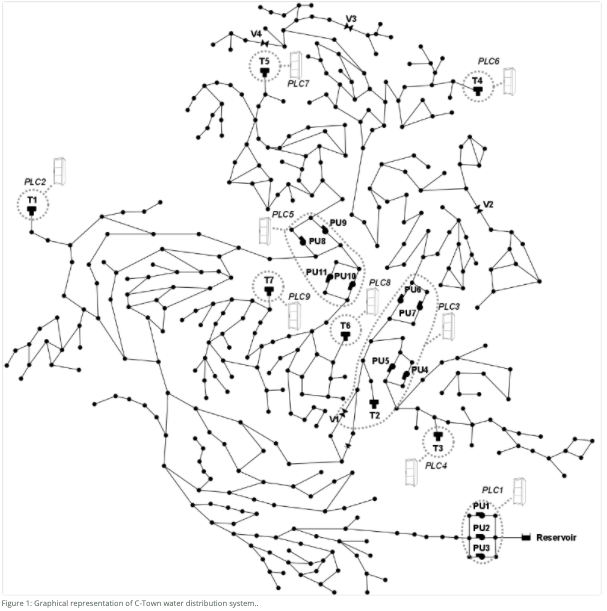

In [2]:
# load training dataset
data_path = ".../data/"
df_train_orig = pd.read_csv("dataset03.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_train_orig.head(2)

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,2014-01-06 00:00:00,0.50973,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,2014-01-06 01:00:00,0.41258,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0


In [3]:
# get dates and columns with sensor readings
dates_train = df_train_orig['DATETIME']
sensor_cols = [col for col in df_train_orig.columns if col not in ['DATETIME','ATT_FLAG']]

# scale sensor data
scaler = MinMaxScaler()
X = pd.DataFrame(index = df_train_orig.index, columns = sensor_cols, data = scaler.fit_transform(df_train_orig[sensor_cols]))

# split into training and validation
X1, X2, _, _  = train_test_split(X, X, test_size=0.33, random_state=42)

### Train autoencoder

In [4]:
# define model parameters
params = {
    'nI' : X.shape[1],
    'nH' : 3,
    'cf' : 2.5,
    'activation' : 'tanh',
    'verbose' : 1,
}

# create AutoEncoder for Event Detection
autoencoder = AE(**params)
autoencoder.initialize()

Created autoencoder with structure:
layer_0: 43, layer_1: 34, layer_2: 25, layer_3: 17, layer_4: 25, layer_5: 34, layer_6: 43


/Users/nazmul/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [5]:
# train models with early stopping and reduction of learning rate on plateau
earlyStopping= EarlyStopping(monitor='val_loss', patience=3, verbose=0,  min_delta=1e-4, mode='auto')
lr_reduced = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=0, epsilon=1e-4, mode='min')
    
# initialize time
start_time = time.time()

# train autoencoder
autoencoder.train(X1.values,
            epochs=500,
            batch_size=32,
            shuffle=False,
            callbacks = [earlyStopping, lr_reduced],
            verbose = 2,
            validation_data=(X2.values, X2.values))



Epoch 1/500
184/184 - 9s - loss: 0.0905 - val_loss: 0.0404
Epoch 2/500
184/184 - 0s - loss: 0.0265 - val_loss: 0.0172
Epoch 3/500
184/184 - 0s - loss: 0.0141 - val_loss: 0.0101
Epoch 4/500
184/184 - 0s - loss: 0.0091 - val_loss: 0.0079
Epoch 5/500
184/184 - 0s - loss: 0.0075 - val_loss: 0.0067
Epoch 6/500
184/184 - 0s - loss: 0.0061 - val_loss: 0.0054
Epoch 7/500
184/184 - 0s - loss: 0.0048 - val_loss: 0.0042
Epoch 8/500
184/184 - 0s - loss: 0.0038 - val_loss: 0.0035
Epoch 9/500
184/184 - 0s - loss: 0.0032 - val_loss: 0.0030
Epoch 10/500
184/184 - 0s - loss: 0.0029 - val_loss: 0.0027
Epoch 11/500
184/184 - 0s - loss: 0.0027 - val_loss: 0.0025
Epoch 12/500
184/184 - 0s - loss: 0.0024 - val_loss: 0.0022
Epoch 13/500
184/184 - 0s - loss: 0.0021 - val_loss: 0.0019
Epoch 14/500
184/184 - 0s - loss: 0.0018 - val_loss: 0.0016
Epoch 15/500
184/184 - 0s - loss: 0.0016 - val_loss: 0.0015
Epoch 16/500
184/184 - 0s - loss: 0.0015 - val_loss: 0.0014
Epoch 17/500
184/184 - 0s - loss: 0.0013 - val_lo

### Test autoencoder

In [6]:
# assess detection
def compute_scores(Y,Yhat):
    return [accuracy_score(Y,Yhat),f1_score(Y,Yhat),precision_score(Y,Yhat),recall_score(Y,Yhat)]

[Text(0, 0, 'NO ATTACK'), Text(0, 1, 'ATTACK')]

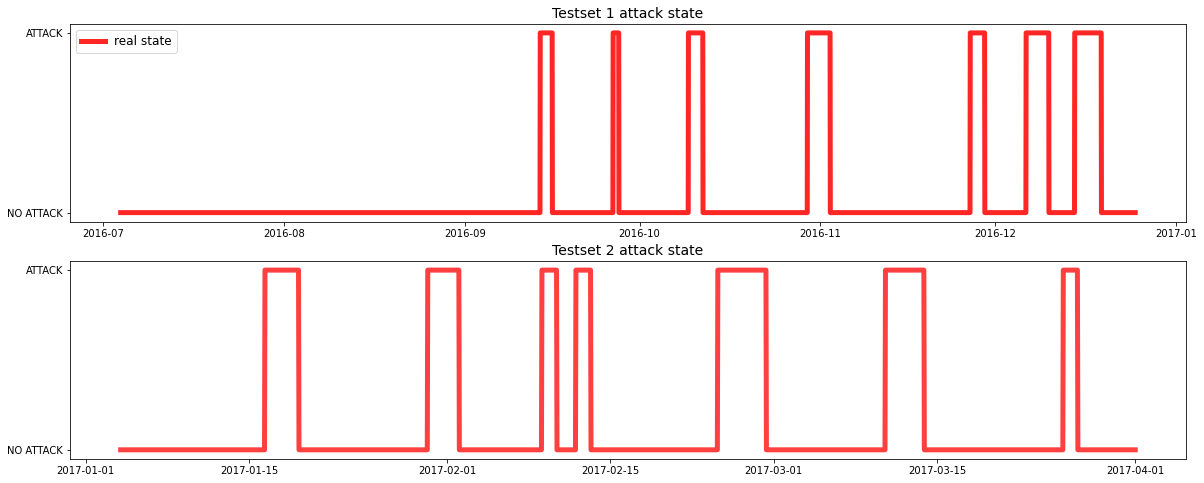

In [7]:
# Load dataset with attacks
df_test_01 = pd.read_csv("dataset04.csv", parse_dates = ['DATETIME'], dayfirst=True)
df_test_02 = pd.read_csv("test_dataset.csv", parse_dates = ['DATETIME'], dayfirst=True)

# scale datasets
X3 = pd.DataFrame(index = df_test_01.DATETIME, columns = sensor_cols, 
                  data = scaler.transform(df_test_01[sensor_cols]))
X4 = pd.DataFrame(index = df_test_02.DATETIME, columns = sensor_cols, 
                  data = scaler.transform(df_test_02[sensor_cols]))

# get targets
Y3 = df_test_01['ATT_FLAG']
Y4 = df_test_02['ATT_FLAG']

# plot figures
shade_of_gray = '0.75'
f, axes = plt.subplots(2,figsize = (20,8))
axes[0].plot(X3.index, Y3, color = 'r', alpha = 0.85, lw = 5, label = 'real state')
axes[0].set_title('Testset 1 attack state', fontsize = 14)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'])
axes[0].legend(fontsize = 12, loc = 2)


axes[1].plot(X4.index, Y4, color = 'r', alpha = 0.75, lw = 5, label = 'real state')
axes[1].set_title('Testset 2 attack state', fontsize = 14)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['NO ATTACK','ATTACK'])

/Users/nazmul/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


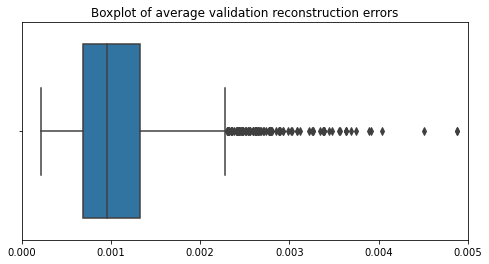

In [8]:
# # perform detection

# get validation reconstruction errors
_, validation_errors = autoencoder.predict(X2)

# plot distribution of average validation reconstruction errors 
f, ax = plt.subplots(1, figsize = (8,4))
sns.boxplot(validation_errors.mean(axis=1), ax=ax)
ax.set_xlim([0,0.005])
ax.set_title('Boxplot of average validation reconstruction errors')

# set treshold as quantile of average reconstruction error
theta = validation_errors.mean(axis = 1).quantile(0.995)

Yhat3, errors3 = autoencoder.detect(X3, theta = theta , window = 3, average=True)
Yhat4, errors4 = autoencoder.detect(X4, theta = theta, window = 3, average=True)

In [9]:
errors3

DATETIME
2016-07-04 00:00:00         NaN
2016-07-04 01:00:00         NaN
2016-07-04 02:00:00    0.002765
2016-07-04 03:00:00    0.003039
2016-07-04 04:00:00    0.003189
                         ...   
2016-12-24 20:00:00    0.001413
2016-12-24 21:00:00    0.002017
2016-12-24 22:00:00    0.002484
2016-12-24 23:00:00    0.018173
2016-12-25 00:00:00    0.033428
Length: 4177, dtype: float64

In [10]:
results = pd.DataFrame(index = ['test dataset 01','test dataset 02'], 
                       columns = ['accuracy','f1_score','precision','recall'])
results.loc['test dataset 01'] = compute_scores(Y3,Yhat3)
results.loc['test dataset 02'] = compute_scores(Y4,Yhat4)

print('Results:\n')
print(results)

Results:

                 accuracy  f1_score precision    recall
test dataset 01  0.952119   0.76247  0.917143  0.652439
test dataset 02  0.932982  0.798851  0.961938  0.683047


### Plot Figure

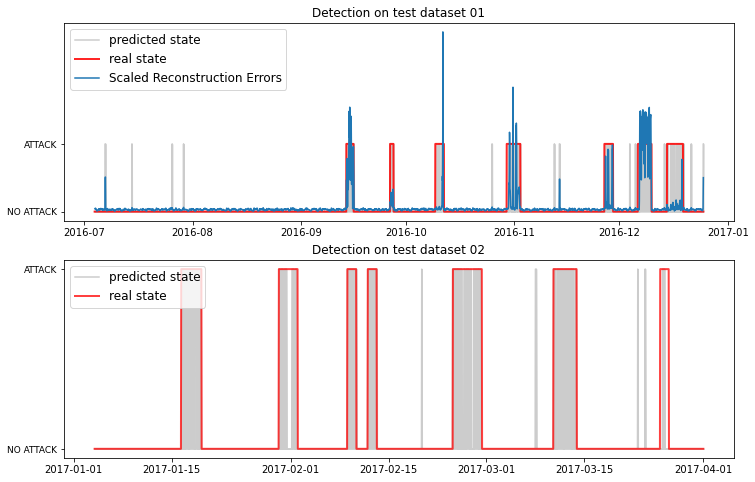

In [11]:
# plot figures
# shade_of_gray = '0.8'
# f, axes = plt.subplots(2,figsize = (20,15))
# axes[0].plot(Yhat3, color = shade_of_gray, label = 'predicted state')
# axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color=shade_of_gray)
# axes[0].plot(Yhat3.index, Y3, color = 'r', alpha = 0.85, lw = 2, label = 'real state')
# axes[0].plot(errors3*15, label = "Scaled Reconstruction Errors")
# axes[0].set_title('Detection on test dataset 01', fontsize = 20)
# axes[0].set_yticks([0,1])
# axes[0].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 18)
# axes[0].legend(fontsize = 20, loc = 2)

# # axes[1].plot(errors3*20, label = "Scaled Reconstruction Errors")
# # axes[1].set_yticks([0,0.5])
# # axes[1].set_yticklabels(['NO ATTACK','ATTACK'])

# axes[1].plot(Yhat4, color = shade_of_gray, label = 'predicted state')
# axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color=shade_of_gray)
# axes[1].plot(Yhat4.index, Y4, color = 'r', alpha = 0.75, lw = 2, label = 'real state')
# axes[1].set_title('Detection on test dataset 02', fontsize = 20)
# axes[1].set_yticks([0,1])
# axes[1].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 18)
# axes[1].legend(fontsize = 20, loc = 2)

shade_of_gray = '0.8'
f, axes = plt.subplots(2,figsize = (12,8))
axes[0].plot(Yhat3, color = shade_of_gray, label = 'predicted state')
axes[0].fill_between(Yhat3.index, Yhat3.values, where=Yhat3.values <=1, interpolate=True, color=shade_of_gray)
axes[0].plot(Yhat3.index, Y3, color = 'r', alpha = 0.85, lw = 2, label = 'real state')
axes[0].plot(errors3*15, label = "Scaled Reconstruction Errors")
axes[0].set_title('Detection on test dataset 01', fontsize = 12)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
axes[0].legend(fontsize = 12, loc = 2)

# axes[1].plot(errors3*20, label = "Scaled Reconstruction Errors")
# axes[1].set_yticks([0,0.5])
# axes[1].set_yticklabels(['NO ATTACK','ATTACK'])

axes[1].plot(Yhat4, color = shade_of_gray, label = 'predicted state')
axes[1].fill_between(Yhat4.index, Yhat4.values, where=Yhat4.values <=1, interpolate=True, color=shade_of_gray)
axes[1].plot(Yhat4.index, Y4, color = 'r', alpha = 0.75, lw = 2, label = 'real state')
axes[1].set_title('Detection on test dataset 02', fontsize = 12)
axes[1].set_yticks([0,1])
axes[1].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
axes[1].legend(fontsize = 12, loc = 2)

plt.savefig('AE.png', dpi=300)  

In [12]:
Yhat3

DATETIME
2016-07-04 00:00:00    False
2016-07-04 01:00:00    False
2016-07-04 02:00:00    False
2016-07-04 03:00:00    False
2016-07-04 04:00:00    False
                       ...  
2016-12-24 20:00:00    False
2016-12-24 21:00:00    False
2016-12-24 22:00:00    False
2016-12-24 23:00:00     True
2016-12-25 00:00:00     True
Length: 4177, dtype: bool

In [13]:
type(errors3)

pandas.core.series.Series

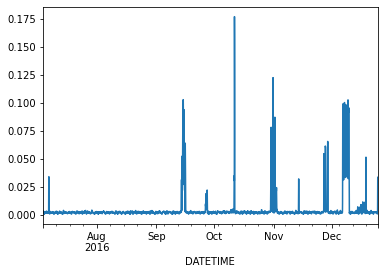

In [14]:
errors3.plot()
plt.savefig('r.png', dpi=300) 

<AxesSubplot:xlabel='DATETIME'>

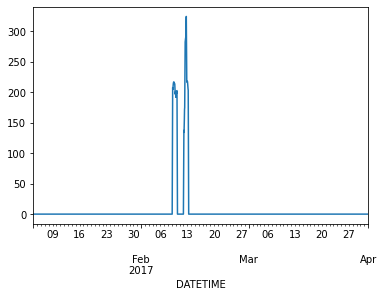

In [15]:
errors4.plot()

### Reconstruction errors for each feature each instance (TestSet 1)

In [16]:

_, validation_errors3 = autoencoder.predict(X3)
validation_errors3

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,F_PU2,...,P_J300,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422
DATETIME,,,,,,,,,,,,,,,,,,,,,
2016-07-04 00:00:00,0.003855,0.011197,0.000269,0.004373,0.002363,0.002362,0.009089,0.000888,0.000011,0.000057,...,0.008168,0.000755,0.008866,1.907678e-12,0.000149,0.000491,0.000444,0.001869,2.991016e-03,0.007875
2016-07-04 01:00:00,0.006734,0.002684,0.000184,0.000283,0.000950,0.000036,0.003228,0.011232,0.000223,0.000876,...,0.000174,0.000501,0.000010,3.540869e-03,0.004685,0.018260,0.009697,0.001249,6.219355e-03,0.000305
2016-07-04 02:00:00,0.006166,0.000003,0.011598,0.001797,0.012746,0.004703,0.001024,0.000112,0.000060,0.001027,...,0.000071,0.001902,0.000067,1.138989e-05,0.002709,0.020375,0.004048,0.002796,5.980094e-03,0.000287
2016-07-04 03:00:00,0.008842,0.003918,0.015820,0.000270,0.001655,0.000844,0.012988,0.001979,0.000298,0.000694,...,0.000966,0.011112,0.002668,2.621833e-03,0.004794,0.000300,0.004809,0.005792,1.537725e-02,0.003898
2016-07-04 04:00:00,0.001176,0.011901,0.000914,0.003828,0.000116,0.000144,0.000181,0.005048,0.000021,0.001461,...,0.008693,0.014932,0.008727,5.991648e-03,0.006535,0.000164,0.007299,0.000133,2.169266e-02,0.012091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-24 20:00:00,0.004705,0.000001,0.006143,0.004315,0.006280,0.003376,0.042049,0.004826,0.000075,0.000020,...,0.001175,0.002403,0.001426,6.964208e-04,0.000090,0.001241,0.003199,0.000046,5.399644e-05,0.001117
2016-12-24 21:00:00,0.000952,0.001748,0.004189,0.016246,0.003986,0.004080,0.028820,0.002259,0.000044,0.001851,...,0.000581,0.001376,0.002625,5.811376e-04,0.000301,0.003752,0.000796,0.000187,4.367408e-05,0.001399
2016-12-24 22:00:00,0.001022,0.002344,0.003520,0.000010,0.003166,0.047055,0.004410,0.009571,0.000036,0.001149,...,0.000003,0.002807,0.000066,6.111822e-05,0.000170,0.005703,0.000236,0.000052,2.094114e-04,0.000032


### Reconstruction errors for each feature each instance (TestSet 2)


In [17]:
_, validation_errors4 = autoencoder.predict(X4)
validation_errors4

,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,F_PU2,...,P_J300,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422
DATETIME,,,,,,,,,,,,,,,,,,,,,
2017-01-04 00:00:00,0.002295,0.006415,0.003619,0.004648,0.006389,4.372914e-04,0.004316,0.004600,3.837334e-05,0.000878,...,0.000638,0.000924,0.001111,0.000050,0.000135,0.000560,0.000082,1.706420e-05,0.003566,0.001582
2017-01-04 01:00:00,0.013512,0.006586,0.001365,0.004303,0.007423,3.200171e-04,0.026972,0.002024,2.331690e-07,0.000746,...,0.001960,0.000115,0.001558,0.000775,0.000194,0.001626,0.000784,7.514972e-04,0.002585,0.001354
2017-01-04 02:00:00,0.010262,0.000003,0.000860,0.000038,0.000329,5.042930e-03,0.002839,0.000009,1.373537e-04,0.002570,...,0.004072,0.002326,0.002612,0.001444,0.001606,0.003099,0.002129,3.201649e-04,0.005514,0.005608
2017-01-04 03:00:00,0.003176,0.000033,0.003676,0.001003,0.000005,2.046988e-04,0.021514,0.000764,1.142159e-06,0.001642,...,0.000343,0.004786,0.000531,0.000036,0.000412,0.000454,0.000064,8.390517e-04,0.001686,0.000428
2017-01-04 04:00:00,0.017866,0.000323,0.000215,0.003627,0.000806,5.001686e-08,0.001377,0.001898,9.685739e-06,0.000233,...,0.000665,0.000870,0.000292,0.006334,0.000434,0.000287,0.000279,2.812624e-03,0.000032,0.000532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-31 20:00:00,0.011099,0.003039,0.004191,0.000111,0.000087,1.718185e-02,0.034040,0.004275,1.055564e-06,0.000703,...,0.000070,0.000049,0.000104,0.001372,0.000901,0.000982,0.000288,6.421285e-04,0.000005,0.000050
2017-03-31 21:00:00,0.003434,0.000385,0.000980,0.000310,0.001984,1.362035e-02,0.035444,0.013808,9.298821e-07,0.002750,...,0.000070,0.000038,0.000041,0.000860,0.000122,0.001918,0.000624,2.828961e-03,0.000463,0.000102
2017-03-31 22:00:00,0.004515,0.005862,0.007511,0.015211,0.002773,3.375936e-02,0.024169,0.018894,1.062690e-05,0.000022,...,0.000036,0.000088,0.000005,0.000219,0.000178,0.002111,0.000091,2.057955e-03,0.000005,0.000007


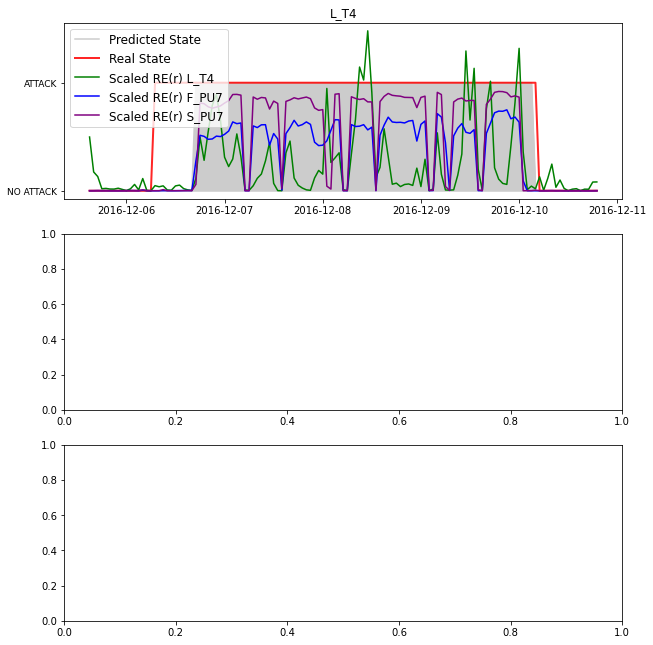

In [18]:

shade_of_gray = '0.8'
f, axes = plt.subplots(3,figsize = (10,11))
axes[0].plot(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
axes[0].fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
axes[0].plot(Yhat3[3711:3836].index, Y3[3711:3836], color = 'r', alpha = 0.85, lw = 2, label = 'Real State')
axes[0].plot(validation_errors3["L_T4"][3711:3836]*15, label = "Scaled RE(r) L_T4", color = 'green')
axes[0].plot(validation_errors3["F_PU7"][3711:3836], label = "Scaled RE(r) F_PU7",color = 'blue')
axes[0].plot(validation_errors3["S_PU7"][3711:3836], label = "Scaled RE(r) S_PU7",color = 'purple')
axes[0].set_title('L_T4', fontsize = 12)
axes[0].set_yticks([0,1])
axes[0].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
axes[0].legend(fontsize = 12, loc = 2)

# axes[1].plot(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
# axes[1].fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
# axes[1].plot(Yhat3[3711:3836].index, Y3[3711:3836], color = 'r', alpha = 0.85, lw = 2, label = 'Real Statee')
# axes[1].plot(validation_errors["F_PU7"][3711:3836], label = "Scaled RE(r)")
# axes[1].set_title('F_PU7', fontsize = 12)
# axes[1].set_yticks([0,1])
# axes[1].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
# axes[1].legend(fontsize = 12, loc = 2)

# axes[2].plot(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
# axes[2].fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
# axes[2].plot(Yhat3[3711:3836].index, Y3[3711:3836], color = 'r', alpha = 0.85, lw = 2, label = 'Real State')
# axes[2].plot(validation_errors["S_PU7"][3711:3836], label = "Scaled RE(r)")
# axes[2].set_title('S_PU7', fontsize = 12)
# axes[2].set_yticks([0,1])
# axes[2].set_yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
# axes[2].legend(fontsize = 12, loc = 2)

#plt.savefig('ALoc.png', dpi=300) 

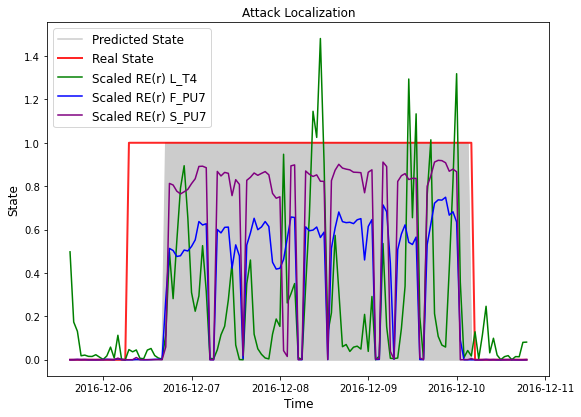

In [26]:
shade_of_gray = '0.8'
# plt.figure(figsize=(8,5))
# plt(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
# plt.fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
# plt(Yhat3[3711:3836].index, Y3[3711:3836], color = 'r', alpha = 0.85, lw = 2, label = 'Real State')
# plt(validation_errors["L_T4"][3711:3836]*15, label = "Scaled RE(r) L_T4", color = 'green')
# plt(validation_errors["F_PU7"][3711:3836], label = "Scaled RE(r) F_PU7",color = 'blue')
# plt(validation_errors["S_PU7"][3711:3836], label = "Scaled RE(r) S_PU7",color = 'purple')
# # plt.title('L_T4', fontsize = 12)
# plt.yticks([0,1])
# plt.yticklabels(['NO ATTACK','ATTACK'],fontsize = 9)
#plt.legend(fontsize = 12, loc = 2)



plt.figure(figsize=(9,6.5))
plt.plot(Yhat3[3711:3836], color = shade_of_gray, label = 'Predicted State')
plt.fill_between(Yhat3[3711:3836].index, Yhat3[3711:3836].values, where=Yhat3[3711:3836].values <=1, interpolate=True, color=shade_of_gray)
plt.plot(Yhat3[3711:3836].index, Y3[3711:3836], color = 'r', alpha = 0.85, lw = 2, label = 'Real State')
plt.plot(validation_errors3["L_T4"][3711:3836]*15, label = "Scaled RE(r) L_T4", color = 'green')
plt.plot(validation_errors3["F_PU7"][3711:3836], label = "Scaled RE(r) F_PU7", color = 'blue')
plt.plot(validation_errors3["S_PU7"][3711:3836], label = "Scaled RE(r) S_PU7", color = 'purple')
plt.xlabel("Time", fontsize = 12)
plt.ylabel('State', fontsize = 12)
plt.title("Attack Localization", fontsize = 12)
plt.legend(labels=['Predicted State','Real State',"Scaled RE(r) L_T4","Scaled RE(r) F_PU7","Scaled RE(r) S_PU7"],fontsize = 12, loc = 2)
plt.savefig('ALoc.png', dpi=300)  
plt.show()

In [20]:
validation_errors["L_T4"][3711:3836]


Series([], Name: L_T4, dtype: float64)